In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn

def transform_data():
    path_to_ny_sales = '../datasets/nyc-property/nyc-rolling-sales.csv'
    sales_df = pd.read_csv(path_to_ny_sales)


    # First transformation
    columns_to_drop = [
        'Unnamed: 0',
        'TAX CLASS AT PRESENT',
        'ZIP CODE',
        'BLOCK',
        'LOT',
        'EASE-MENT',
        'BUILDING CLASS AT PRESENT',
        'TAX CLASS AT TIME OF SALE',
        'BUILDING CLASS AT TIME OF SALE',
        'BUILDING CLASS CATEGORY',
        'NEIGHBORHOOD',
        'ADDRESS',
        'APARTMENT NUMBER',
        'SALE DATE'
    ]
    sales_df = sales_df.drop(columns=columns_to_drop)

    # Second transformation
    columns_to_convert = [
        'LAND SQUARE FEET',
        'GROSS SQUARE FEET',
        'SALE PRICE',
        'YEAR BUILT'
    ]
    for column_name in columns_to_convert:
        sales_df[column_name] = pd.to_numeric(sales_df[column_name], errors='coerce')
        sales_df = sales_df.fillna(-1)

    # Third transformation 
    # hint: look at the check_building_type function defined below
    # hint 2: read the "apply" function's documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
    sales_df['BUILDING TYPE'] = sales_df.apply(check_building_type, axis=1) 
    sales_df = pd.get_dummies(sales_df, columns=['BUILDING TYPE'])

    # Fourth transformation
    sales_df['BOROUGH'] = sales_df['BOROUGH'].map({
        1 : 'Manhattan',
        2 : 'Bronx',
        3 : 'Brooklyn',
        4 : 'Queens',
        5 : 'Staten Island',
    })
    
    # Drop records with absurdly low price values
    sales_df = sales_df[ sales_df['SALE PRICE'] > 1000]
    
    # Write the results to a csv
    return sales_df


# It's better to define functions at the top level, rather than as
# inner functions inside main
def check_building_type(row):
    if row['COMMERCIAL UNITS'] > 0 and row['RESIDENTIAL UNITS'] > 0:
        return "MIXED USE"
    elif row['COMMERCIAL UNITS'] > 0:
        return "COMMERCIAL"
    elif row['RESIDENTIAL UNITS']:
        return "RESIDENTIAL"
    else:
        return "UNKNOWN - NO UNITS"
    
    



In [2]:
transformed_data = transform_data()


In [3]:
transformed_data.describe()

,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,BUILDING TYPE_COMMERCIAL,BUILDING TYPE_MIXED USE,BUILDING TYPE_RESIDENTIAL,BUILDING TYPE_UNKNOWN - NO UNITS
count,58604.000000,58604.000000,58604.000000,5.860400e+04,5.860400e+04,58604.000000,5.860400e+04,58604.000000,58604.000000,58604.000000,58604.000000
mean,1.705583,0.163948,1.881169,2.379285e+03,2.229247e+03,1811.956146,1.524388e+06,0.021773,0.024896,0.659051,0.294280
std,14.172163,9.917320,17.404054,3.545480e+04,2.386362e+04,502.802463,1.244863e+07,0.145944,0.155809,0.474032,0.455722
min,0.000000,0.000000,0.000000,-1.000000e+00,-1.000000e+00,0.000000,1.110000e+03,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-1.000000e+00,-1.000000e+00,1920.000000,3.850000e+05,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,7.565000e+02,0.000000e+00,1940.000000,6.390865e+05,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,2.000000,2.500000e+03,1.836000e+03,1966.000000,1.097755e+06,0.000000,0.000000,1.000000,1.000000
max,1844.000000,2261.000000,2261.000000,4.252327e+06,3.750565e+06,2017.000000,2.210000e+09,1.000000,1.000000,1.000000,1.000000


In [4]:
def train_and_report(dataset, model):
    print(f'Training the {model} model')

    labels = dataset['BOROUGH']
    features = dataset.drop(labels='BOROUGH', axis=1)

    # RandomState so we always use the same test/train split.
    # Stratify to ensure the train/test buckets contain the same makeup of class values (not balanced, but 20% of each class is in the test set)
    training_data, test_data, training_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=50, stratify=labels)

    model.fit(training_data, training_labels)

    train_score = model.score(training_data, training_labels)
    test_score = model.score(test_data, test_labels)
    
    print("======== Reporting =========")

    print(f"train: {train_score}, test: {test_score}")
    
    predictions = model.predict(transformed_data.drop(columns='BOROUGH'))

    print("\nNumber of predictions by class")
    print(pd.DataFrame(predictions).value_counts())
    
    print("\nNumber of true labels by class")
    print(transformed_data['BOROUGH'].value_counts())
    
    print("\nConfusion Matrix (all data, not just train or test)")
    cm = confusion_matrix(transformed_data['BOROUGH'], predictions)
    name_labels = model.classes_
    sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels, fmt='g') # fmt='g' prevents scientific notation here
    plt.show()
    
    print("\nConfusion Matrix (Just training data)")
    cm = confusion_matrix(training_labels, model.predict(training_data))
    sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels, fmt='g') 
    plt.show()
    
    print("\nConfusion Matrix (Just test data)")
    cm = confusion_matrix(test_labels, model.predict(test_data))
    sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels, fmt='g') 
    plt.show()

    
    return model

Training the LogisticRegression(max_iter=100000) model
======== Reporting =========
train: 0.46707761875306614, test: 0.4589198873816227

Number of predictions by class
Manhattan        27881
Queens           27026
Brooklyn          3151
Staten Island      525
Bronx               21
dtype: int64

Number of true labels by class
Queens           18098
Brooklyn         15335
Manhattan        14298
Staten Island     5866
Bronx             5007
Name: BOROUGH, dtype: int64

Confusion Matrix (all data, not just train or test)


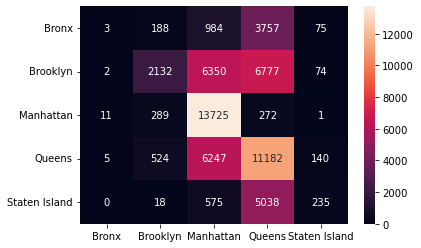


Confusion Matrix (Just training data)


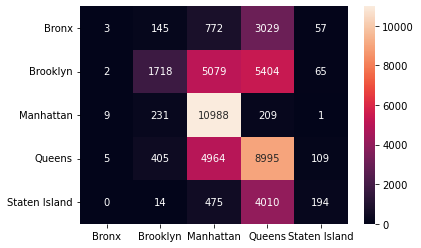


Confusion Matrix (Just test data)


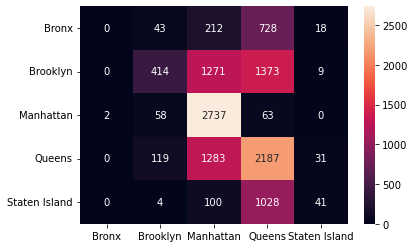

Training the LogisticRegression(max_iter=1000, multi_class='ovr') model
======== Reporting =========
train: 0.5053217584198963, test: 0.5031993857179422

Number of predictions by class
Queens           34873
Manhattan        20372
Brooklyn          2775
Staten Island      574
Bronx               10
dtype: int64

Number of true labels by class
Queens           18098
Brooklyn         15335
Manhattan        14298
Staten Island     5866
Bronx             5007
Name: BOROUGH, dtype: int64

Confusion Matrix (all data, not just train or test)


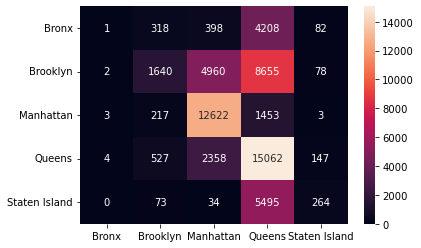


Confusion Matrix (Just training data)


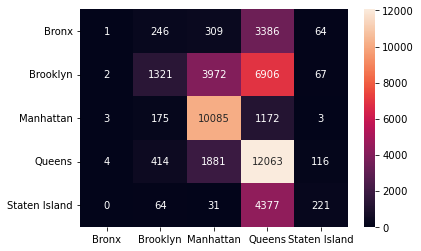


Confusion Matrix (Just test data)


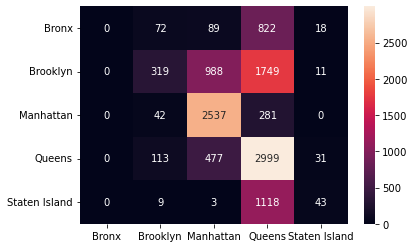

Training the DecisionTreeClassifier() model
======== Reporting =========
train: 0.9911481773777275, test: 0.7472058698063305

Number of predictions by class
Queens           17922
Brooklyn         15195
Manhattan        14493
Staten Island     5826
Bronx             5168
dtype: int64

Number of true labels by class
Queens           18098
Brooklyn         15335
Manhattan        14298
Staten Island     5866
Bronx             5007
Name: BOROUGH, dtype: int64

Confusion Matrix (all data, not just train or test)


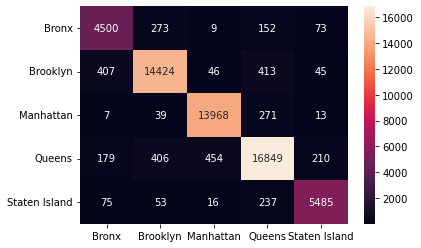


Confusion Matrix (Just training data)


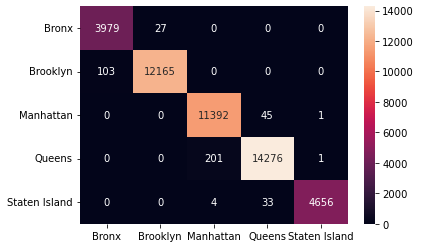


Confusion Matrix (Just test data)


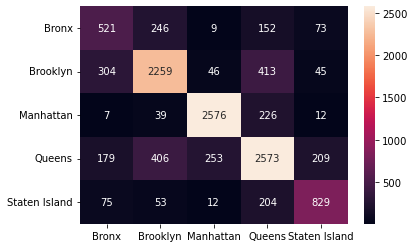

Training the DecisionTreeClassifier(min_samples_leaf=30) model
======== Reporting =========
train: 0.7955548919651046, test: 0.7666581349714188

Number of predictions by class
Queens           18702
Brooklyn         15424
Manhattan        14468
Staten Island     5720
Bronx             4290
dtype: int64

Number of true labels by class
Queens           18098
Brooklyn         15335
Manhattan        14298
Staten Island     5866
Bronx             5007
Name: BOROUGH, dtype: int64

Confusion Matrix (all data, not just train or test)


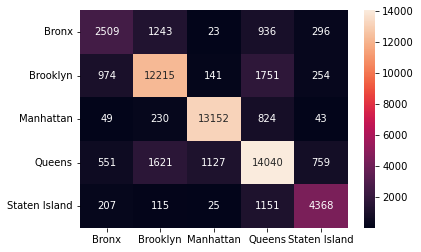


Confusion Matrix (Just training data)


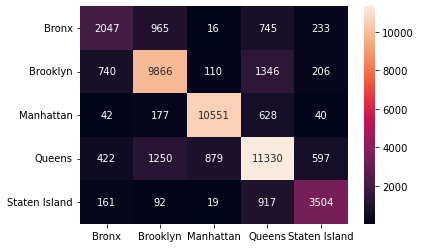


Confusion Matrix (Just test data)


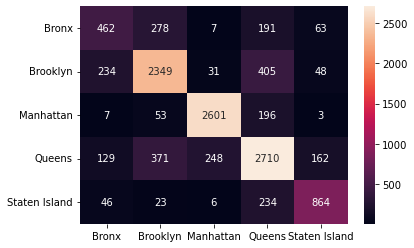

Training the DecisionTreeClassifier(max_depth=10) model
======== Reporting =========
train: 0.7872149819764094, test: 0.7594061940107499

Number of predictions by class
Queens           18628
Brooklyn         15834
Manhattan        14384
Staten Island     5541
Bronx             4217
dtype: int64

Number of true labels by class
Queens           18098
Brooklyn         15335
Manhattan        14298
Staten Island     5866
Bronx             5007
Name: BOROUGH, dtype: int64

Confusion Matrix (all data, not just train or test)


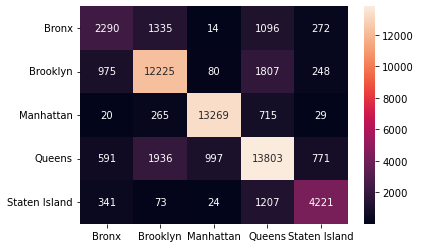


Confusion Matrix (Just training data)


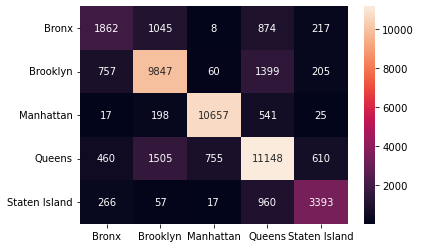


Confusion Matrix (Just test data)


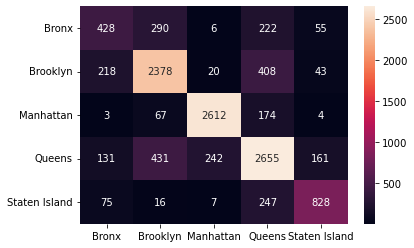

Training the RandomForestClassifier() model
======== Reporting =========
train: 0.9910841882985304, test: 0.7915706850951284

Number of predictions by class
Queens           18323
Brooklyn         15328
Manhattan        14310
Staten Island     5782
Bronx             4861
dtype: int64

Number of true labels by class
Queens           18098
Brooklyn         15335
Manhattan        14298
Staten Island     5866
Bronx             5007
Name: BOROUGH, dtype: int64

Confusion Matrix (all data, not just train or test)


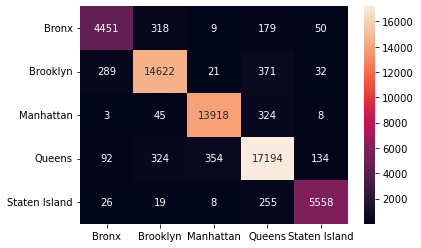


Confusion Matrix (Just training data)


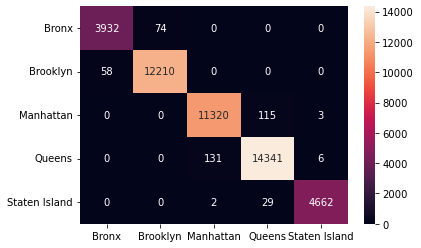


Confusion Matrix (Just test data)


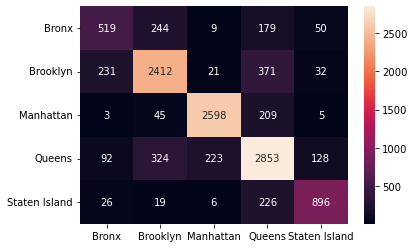

Training the RandomForestClassifier(max_depth=4, n_estimators=200) model
======== Reporting =========
train: 0.6873920184288548, test: 0.6885078065011517

Number of predictions by class
Queens           23349
Brooklyn         16995
Manhattan        15545
Staten Island     2715
dtype: int64

Number of true labels by class
Queens           18098
Brooklyn         15335
Manhattan        14298
Staten Island     5866
Bronx             5007
Name: BOROUGH, dtype: int64

Confusion Matrix (all data, not just train or test)


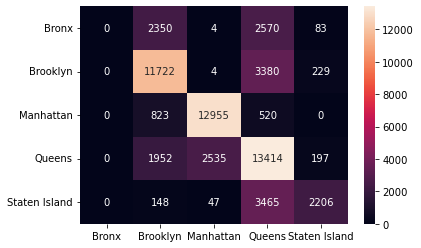


Confusion Matrix (Just training data)


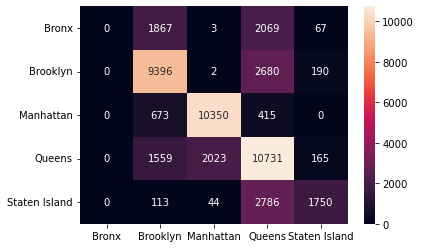


Confusion Matrix (Just test data)


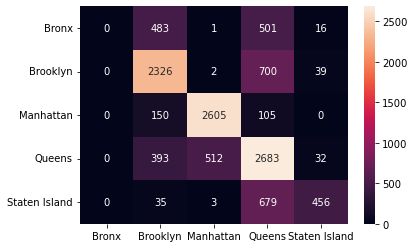

Training the RandomForestClassifier(max_depth=6, n_estimators=200) model
======== Reporting =========
train: 0.741078855875264, test: 0.7369678355089156

Number of predictions by class
Queens           22240
Brooklyn         16175
Manhattan        14875
Staten Island     4775
Bronx              539
dtype: int64

Number of true labels by class
Queens           18098
Brooklyn         15335
Manhattan        14298
Staten Island     5866
Bronx             5007
Name: BOROUGH, dtype: int64

Confusion Matrix (all data, not just train or test)


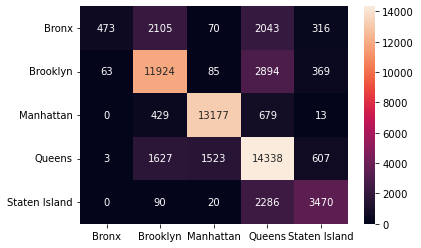


Confusion Matrix (Just training data)


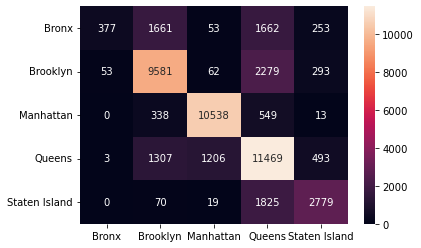


Confusion Matrix (Just test data)


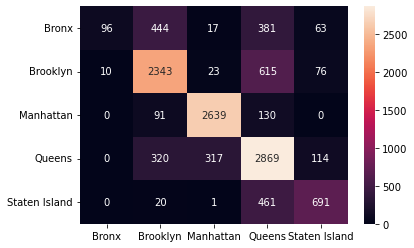

Training the RandomForestClassifier(min_samples_leaf=30, n_estimators=200) model
======== Reporting =========
train: 0.7893692809760467, test: 0.7706680317379063

Number of predictions by class
Queens           20007
Brooklyn         15995
Manhattan        15004
Staten Island     5034
Bronx             2564
dtype: int64

Number of true labels by class
Queens           18098
Brooklyn         15335
Manhattan        14298
Staten Island     5866
Bronx             5007
Name: BOROUGH, dtype: int64

Confusion Matrix (all data, not just train or test)


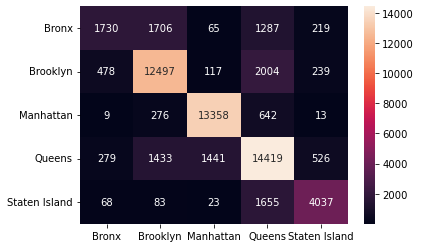


Confusion Matrix (Just training data)


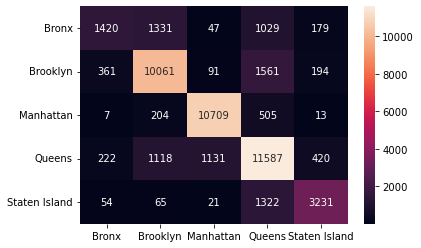


Confusion Matrix (Just test data)


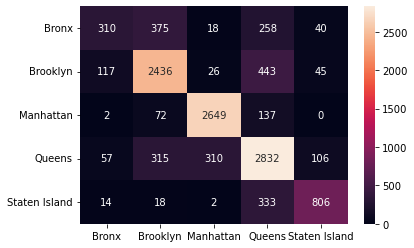

In [5]:
models = [
    LogisticRegression(max_iter=100000),
    LogisticRegression(max_iter=1000, multi_class='ovr'),
    DecisionTreeClassifier(),
    DecisionTreeClassifier(min_samples_leaf=30),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(),
    RandomForestClassifier(n_estimators=200, max_depth=4),
    RandomForestClassifier(n_estimators=200, max_depth=6),
    RandomForestClassifier(n_estimators=200, min_samples_leaf=30)
]

for model in models:
    trained_model = train_and_report(transformed_data, model)